In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pydicom import read_file
import copy
import sys
import glob
from copy import deepcopy
from scipy import stats
from matplotlib.gridspec import GridSpec
import tqdm 
import seaborn as sns
%matplotlib inline

PROJ_DIR = "/home/olle/PycharmProjects/LODE"

sys.path.insert(0, os.path.join(PROJ_DIR, 'feature_statistics/utils'))

import statistics_utils as su

plt.style.use('seaborn')

WORK_SPACE = "/home/olle/PycharmProjects/LODE/workspace"

oct_meta_pd = pd.read_csv(os.path.join(WORK_SPACE, "joint_export/export_tables/oct_meta_information.csv"))

oct_meta_pd.loc[:, "sequence"] = oct_meta_pd.PATNR.astype(str) + "_" + oct_meta_pd.laterality

data_pd = pd.read_csv( os.path.join(WORK_SPACE, 
                                    "joint_export/sequence_data/longitudinal_properties_naive.csv"))


## filter and preprocess data tables

In [9]:
filter_1, filter_3, filter_6, filter_12 = su.filter_time_ranges(data_pd)

data_pd = su.preprocess_dataframe(data_pd, oct_meta_pd)

Number of filtered sequences for 3 months are: 346
Number of filtered sequences for 6 months are: 332
Number of filtered sequences for 12 months are: 278


In [10]:
## Create data visualizations

In [11]:
seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis", 
               "atropypercentage", "thicknessmean"]

seg_delta = []
seg_times = [1, 3, 12]

assert su.assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = su.get_seg_independents_str(seg_features, seg_delta, seg_times)

va_delta = []
va_times = [1, 3, 12]

assert su.assert_times(va_times), "Selected time points contains not allowed values"

va_independents = su.get_va_dependents_str(va_delta, va_times)

injection_times = [3]

assert su.assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_independents.append(f"n_injections_{it}")
    
time_filters = {1: filter_1, 3: filter_3, 6: filter_6, 12: filter_12}


abt = su.associate_time_n_factors(table=data_pd, spatial_sum=True, time_filters=time_filters, 
                               times=[1, 3, 12])

abt_spatial = su.associate_time_n_factors(table=data_pd, spatial_sum=False, time_filters=time_filters,
                                       times=[1, 3, 12])

seg_indeps = []
for segtime in seg_times:
    seg_indeps.extend(abt.loc[:, ~abt.columns.str.contains("15")].columns.values.tolist())
        
# filter out va columns
# seg_indeps = [i for i in seg_indeps if "va" not in i]
#seg_indeps = [i for i in seg_indeps if "injections" not in i]
seg_indeps = [i for i in seg_indeps if "delta" not in i]


independent_variables = injection_independents + seg_indeps + ["cur_va_rounded_1"]

abt_viz = abt[independent_variables]

# drop duplicate columns
abt_viz = abt_viz.loc[:,~abt_viz.columns.duplicated()]

# add all first order interactions
columns = copy.copy(abt_viz.columns)
            
indep_vars_interactions = list(abt_viz.columns)

abt_viz["va_change"] = abt.cur_va_rounded_12 - abt.cur_va_rounded_1

## join in cataract information

In [12]:
cols_to_merge = ['cataract_surgery_before_sequence', 'cataract_surgery_3',
       'cataract_surgery_6', 'cataract_surgery_12', 'cataract_surgery_24', "sequence"]

abt_viz = pd.merge(abt_viz, data_pd[cols_to_merge], left_on="sequence", right_on="sequence", how="left") 

In [13]:
print("number of eyes with cataract before", data_pd.cataract_surgery_before_sequence.sum())
print("number of eyes with cataract 3", data_pd.cataract_surgery_3.sum())
print("number of eyes with cataract 6", data_pd.cataract_surgery_6.sum())
print("number of eyes with cataract 12", data_pd.cataract_surgery_12.sum())
print("number of eyes with cataract 24", data_pd.cataract_surgery_24.sum())

number of eyes with cataract before 215.0
number of eyes with cataract 3 64.0
number of eyes with cataract 6 2.0
number of eyes with cataract 12 15.0
number of eyes with cataract 24 20.0


In [14]:
print("number of eyes with cataract before", abt_viz.cataract_surgery_before_sequence.sum())
print("number of eyes with cataract 3", abt_viz.cataract_surgery_3.sum())
print("number of eyes with cataract 6", abt_viz.cataract_surgery_6.sum())
print("number of eyes with cataract 12", abt_viz.cataract_surgery_12.sum())

number of eyes with cataract before 67.0
number of eyes with cataract 3 25.0
number of eyes with cataract 6 0.0
number of eyes with cataract 12 4.0


# merge in age and gender information

In [15]:
oct_meta_pd_sub = oct_meta_pd[oct_meta_pd.sequence.isin(list(abt_viz.index))].drop_duplicates(subset=["sequence"])

In [16]:
abt_viz = pd.merge(abt_viz, oct_meta_pd_sub[["sequence", "gender", "age"]].drop_duplicates(), 
                   on="sequence", how="left",)

## get base statistics

In [17]:
abt_viz.columns.values

array(['sequence', 'n_injections_3', 'cur_va_rounded_1',
       'cur_va_rounded_3', 'cur_va_rounded_12', 'epm_1', 'irf_1', 'srf_1',
       'srhm_1', 'rpe_1', 'fvpde_1', 'drusen_1', 'phm_1', 'choroid_1',
       'fibrosis_1', 'atropypercentage_1', 'thicknessmean_1', 'epm_3',
       'irf_3', 'srf_3', 'srhm_3', 'rpe_3', 'fvpde_3', 'drusen_3',
       'phm_3', 'choroid_3', 'fibrosis_3', 'atropypercentage_3',
       'thicknessmean_3', 'epm_12', 'irf_12', 'srf_12', 'srhm_12',
       'rpe_12', 'fvpde_12', 'drusen_12', 'phm_12', 'choroid_12',
       'fibrosis_12', 'atropypercentage_12', 'thicknessmean_12',
       'n_injections_12', 'va_change', 'cataract_surgery_before_sequence',
       'cataract_surgery_3', 'cataract_surgery_6', 'cataract_surgery_12',
       'cataract_surgery_24', 'gender', 'age'], dtype=object)

In [18]:
print("Mean age: ", np.mean(abt_viz.age), np.std(abt_viz.age))
print("sex distribution: ", np.unique(abt_viz.gender, return_counts=1))
print("injection month 3: ", np.mean(abt_viz.n_injections_3), np.std(abt_viz.n_injections_3))
print("injections month 12: ", np.mean(abt_viz.n_injections_12), np.std(abt_viz.n_injections_12))


Mean age:  nan nan
sex distribution:  (array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan

In [30]:
def get_time_dict(feature, time_point, data_pd, feature_change, time_filters, spatial_sum=True):
    data_temp = su.associate_time_n_factors(table=data_pd, spatial_sum=spatial_sum, time_filters=time_filters,
                                         times=[1, time_point])
    
    # calc feature delta
    feature_delta = data_temp[f"{feature}_{time_point}"] - data_temp[f"{feature}_{1}"]
    
    # get data points for feature increase or decrease cases
    if feature_change == "increase":
        data_temp = data_temp[feature_delta >= 0]
    else:
        data_temp = data_temp[feature_delta < 0]
        
    feature_columns = data_temp[[f"{feature}_{time_point}"]]
    feature_columns.loc[:, "va_change"] = data_temp[f"cur_va_rounded_{time_point}"] - data_temp["cur_va_rounded_1"]

    feature_columns["va_class"] = None
    feature_columns["va_class"][feature_columns.va_change > 0.15] = 0
    feature_columns["va_class"][(feature_columns.va_change > -0.15) & (feature_columns.va_change <= 0.15)] = 1
    feature_columns["va_class"][feature_columns.va_change <= -0.15] = 2
    
    n_injections = np.round(data_temp[f"n_injections_{time_point}"].mean(),2)
    
    dict_ = dict(feature_columns.va_class.value_counts())
    dict_[f"injections"] = n_injections
    return dict_

def plot_stacked_bar(viz_dict, time, x_pos):
    
    lost = np.array([viz_dict[time][0]])
    no_change = np.array([viz_dict[time][1]])
    gained = np.array([viz_dict[time][2]])

    # memo of sample number
    snum = lost+no_change+gained

    # normalization
    y1 = lost/snum*100.
    y2 = no_change/snum*100.
    y3 = gained/snum*100.
    
    width = 0.2
    
    # stack bars
    plt.bar(x_pos, y1, color="tab:red", width=width)
    plt.bar(x_pos, y2 , bottom=y1, color="tab:blue", width=width)
    plt.bar(x_pos, y3 , bottom=y1+y2, color="tab:green", width=width)

    # add text annotation corresponding to the percentage of each data.
    for xpos, ypos, yval in zip([x_pos], y1/2, y1):
        plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
    for xpos, ypos, yval in zip([x_pos], y1+y2/2, y2):
        plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
    for xpos, ypos, yval in zip([x_pos], y1+y2+y3/2, y3):
        plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
    
    # add text annotation corresponding to the "total" value of each bar
    for xpos, ypos, yval in zip([x_pos], y1+y2+y3, snum):
        plt.text(xpos, ypos, "N=%d"%yval, ha="center", va="bottom")
        plt.text(xpos, ypos + 4, "mean_inj=%d"%viz_dict[time]["injections"], ha="center", va="bottom")

    plt.ylim(0,110)

## Plot 1 Feature distribution

In [20]:
## add special features
abt_viz = pd.merge(abt_viz, abt_spatial[["C0-choroid_1", 
                                         "C0-choroid_3", 
                                         "C0-choroid_12", 
                                         "C0-thicknessmean_1",
                                         "C0-thicknessmean_3", 
                                         "C0-thicknessmean_12"]], on="sequence")

cataract_f = abt_viz[~abt_viz.cataract_surgery_12.fillna(0).astype(bool)]

In [21]:
feature_list = ["C0-thicknessmean", "C0-choroid", "irf", "rpe", "srf", "srhm", "rpe", "fvpde", "fibrosis", "drusen"]

time_feature_list = []
time_points = [1, 3, 12]
for time in time_points:
    for feature in feature_list:
        time_feature_list.append(f"{feature}_{time}")
        
plot1_ = [i for i in cataract_f.columns.tolist() if i in time_feature_list]

plot1_abt = cataract_f[plot1_ + ["cataract_surgery_before_sequence"]]

plot1_abt.loc[:, "cataract_surgery_before_sequence"] = plot1_abt.cataract_surgery_before_sequence.fillna(0.0)

In [22]:
## check examples
feature = "thicknessmean"
sequence = "15425_R"
seq_pd = cataract_f[cataract_f.sequence == sequence]
feature_cols = ["sequence"] + [col for col in seq_pd.columns.tolist() if feature in col]

seq_pd[feature_cols]

,sequence,thicknessmean_1,thicknessmean_3,thicknessmean_12,C0-thicknessmean_1,C0-thicknessmean_3,C0-thicknessmean_12
16,15425_R,2.864702,3.359947,4.156451,0.199164,0.231573,0.296391


In [23]:
plot1_abt.columns.values

array(['irf_1', 'srf_1', 'srhm_1', 'rpe_1', 'fvpde_1', 'drusen_1',
       'fibrosis_1', 'irf_3', 'srf_3', 'srhm_3', 'rpe_3', 'fvpde_3',
       'drusen_3', 'fibrosis_3', 'irf_12', 'srf_12', 'srhm_12', 'rpe_12',
       'fvpde_12', 'drusen_12', 'fibrosis_12', 'C0-choroid_1',
       'C0-choroid_3', 'C0-choroid_12', 'C0-thicknessmean_1',
       'C0-thicknessmean_3', 'C0-thicknessmean_12',
       'cataract_surgery_before_sequence'], dtype=object)

Text(0.5, 0.98, 'OCT bio marker change under antiVEGF treatment')

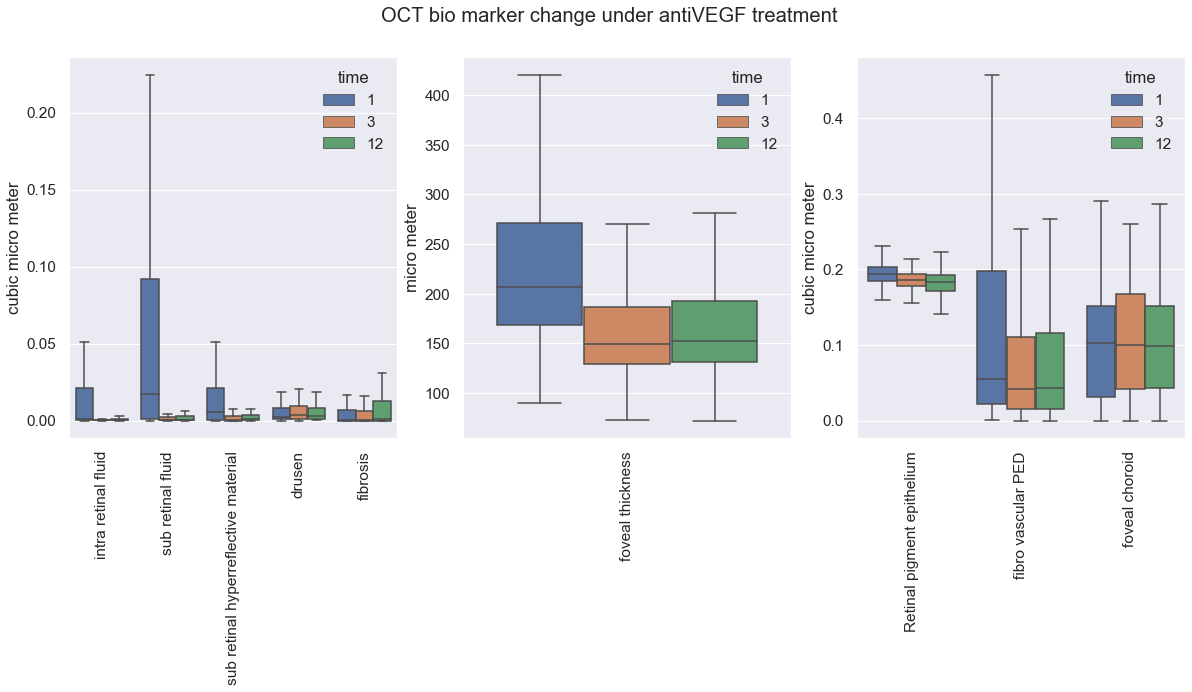

In [27]:
sns.set(font_scale=1.4)
plot1_abt_long = plot1_abt.melt(id_vars=["cataract_surgery_before_sequence"])

plot1_abt_long.loc[:, "time"] = plot1_abt_long.variable.str.split("_", expand=True)[1]
plot1_abt_long.loc[:, "feature"] = plot1_abt_long.variable.str.split("_", expand=True)[0]

small_ = plot1_abt_long.feature.isin(["irf", "srf", "srhm", "drusen", "fibrosis"])
large_ = plot1_abt_long.feature.isin(["fvpde", "rpe", "C0-choroid"])
thickness_ = plot1_abt_long.feature.isin(["C0-thicknessmean"])

cataract_surgery = plot1_abt_long.cataract_surgery_before_sequence == 1.0

plot1_abt_long = plot1_abt_long.rename(columns={"value":"cubim mm"})

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

g0 = sns.boxplot(x="feature", y="cubim mm", hue="time",
            data=plot1_abt_long[small_], 
            showfliers=False, ax=axes[0]);

g0.set(xticks=[0,1,2,3,4])
g0.set_xticklabels(['intra retinal fluid','sub retinal fluid','sub retinal hyperreflective material',
                    'drusen','fibrosis'], rotation=90)

axes[0].set_ylabel("cubic micro meter")


g1 = sns.boxplot(x="feature", y="cubim mm", hue="time",
            data=plot1_abt_long[thickness_], 
            showfliers=False, ax=axes[1]);

axes[1].set_ylabel("micro meter")

g1.set(xticks=[0])
g1.set_xticklabels(['foveal thickness'], rotation=90)

g2 = sns.boxplot(x="feature", y="cubim mm",
            hue="time",
            data=plot1_abt_long[large_], 
            showfliers=False, ax=axes[2] );

g2.set(xticks=[0,1,2])
g2.set_xticklabels(['Retinal pigment epithelium','fibro vascular PED','foveal choroid'], rotation=90)

axes[2].set_ylabel("cubic micro meter")

axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

plt.suptitle("OCT bio marker change under antiVEGF treatment")

# Plot 2 Time until dry

In [28]:
fluid_1 = abt_viz[["irf_1", "srf_1"]].sum(1)
fluid_3 = abt_viz[["irf_3", "srf_3"]].sum(1)
fluid_12 = abt_viz[["irf_12", "srf_12"]].sum(1)

print(f"Number of dry eyes a time point 1: {sum(fluid_1 == 0)}")
print(f"Number of dry eyes a time point 3: {sum(fluid_3 == 0)}")
print(f"Number of dry eyes a time point 12: {sum(fluid_12== 0) }")

Number of dry eyes a time point 1: 3
Number of dry eyes a time point 3: 15
Number of dry eyes a time point 12: 13


Text(0.5, 1.0, 'distribution of thicknessmean among eyes with increased, decreased \n and unchanged visual acuity')

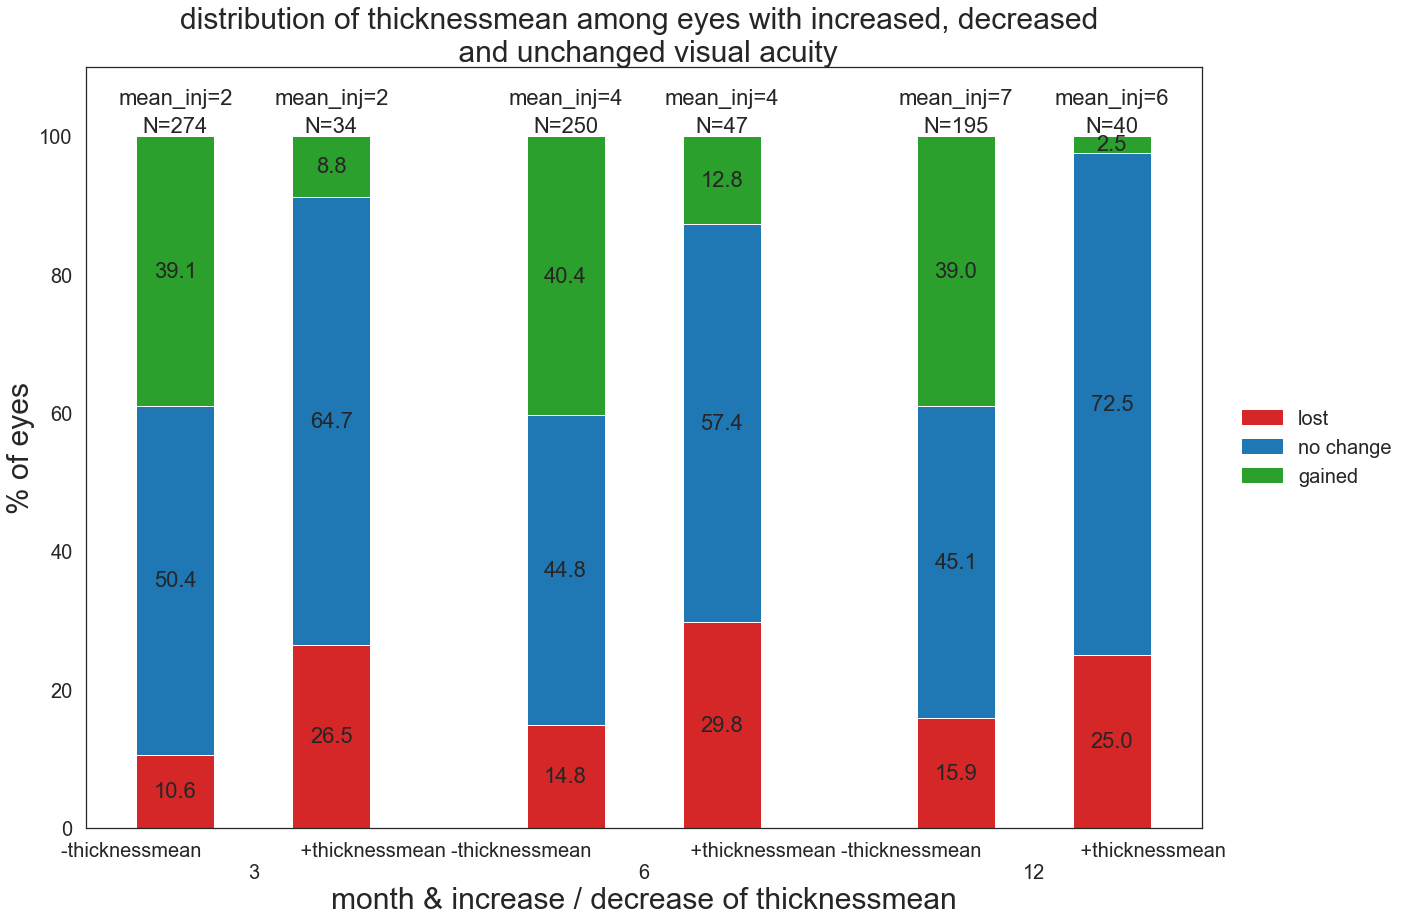

In [31]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib

sns.set_style("white")

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

feature = "thicknessmean"
spatial_sum = True

cataract_bool = (data_pd.cataract_surgery_3 > 0) | (data_pd.cataract_surgery_6 > 0) | \
(data_pd.cataract_surgery_12 > 0)

data_f_pd = data_pd[~cataract_bool]

viz_dict_increased = {}

viz_dict_increased["3"] = get_time_dict(feature, 3, data_f_pd, feature_change="increase", 
                                        time_filters=time_filters,
                                        spatial_sum=spatial_sum)
viz_dict_increased["6"] = get_time_dict(feature, 6, data_f_pd, feature_change="increase", 
                                        time_filters=time_filters,
                                        spatial_sum=spatial_sum)
viz_dict_increased["12"] = get_time_dict(feature, 12, data_f_pd, feature_change="increase", 
                                         time_filters=time_filters,
                                         spatial_sum=spatial_sum)

viz_dict_decreased = {}
viz_dict_decreased["3"] = get_time_dict(feature, 3, data_f_pd, feature_change="decrease", 
                                        time_filters=time_filters,
                                        spatial_sum=spatial_sum)
viz_dict_decreased["6"] = get_time_dict(feature, 6, data_f_pd, feature_change="decrease", 
                                        time_filters=time_filters,
                                        spatial_sum=spatial_sum)
viz_dict_decreased["12"] = get_time_dict(feature, 12, data_f_pd, feature_change="decrease", 
                                         time_filters=time_filters,
                                         spatial_sum=spatial_sum)


plt.figure(figsize=(20,14))

plot_stacked_bar(viz_dict_decreased, time="3", x_pos=1 - 0.2)
plot_stacked_bar(viz_dict_decreased, time="6", x_pos=2 - 0.2)
plot_stacked_bar(viz_dict_decreased, time="12", x_pos=3 - 0.2)

plot_stacked_bar(viz_dict_increased, time="3", x_pos=1 + 0.2)
plot_stacked_bar(viz_dict_increased, time="6", x_pos=2 + 0.2)
plot_stacked_bar(viz_dict_increased, time="12", x_pos=3 + 0.2)

red_patch = mpatches.Patch(color='tab:red', label='lost')
blue_patch = mpatches.Patch(color='tab:blue', label='no change')
green_patch = mpatches.Patch(color='tab:green', label='gained')

plt.legend(handles=[red_patch, blue_patch, green_patch], bbox_to_anchor=(1.02,0.5), loc='center left',
          prop={'size': 20})

space = "                  "
plt.xticks([1,2,3], labels=[f"-{feature}{space}+{feature}\n3", 
                            f"-{feature}{space}+{feature}\n6", 
                            f"-{feature}{space}+{feature}\n12"])

plt.ylabel("% of eyes", size=30)
plt.xlabel(f"month & increase / decrease of {feature}", size=30)
plt.title(f"distribution of {feature} among eyes with increased, decreased \n and unchanged visual acuity",
         size=30)

## simple statistics for paper

In [54]:
## Number of eyes recieving Anti-VEGF

cumsum_injections = abt_viz.n_injections_3 + abt_viz.n_injections_12

print("number of patients recieving anti-VEGF", np.sum(cumsum_injections > 0))

# treatment start & end dates
min_ = data_pd[filter_1 & filter_3 & filter_12].study_date_1.min()
max_ = data_pd[filter_1 & filter_3 & filter_12].study_date_12.max()

print("first treatment was: ", min_, "last treatment was: ", max_)

number of patients recieving anti-VEGF 206
first treatment was:  2013-03-11 last treatment was:  2020-07-09


first treatment was:  2013-03-11 last treatment was:  2020-07-09


## print statistics data

In [24]:
plot1_abt.loc[:, "C0-thicknessmean_1"] = plot1_abt.loc[:, "C0-thicknessmean_1"] * 1000
plot1_abt.loc[:, "C0-thicknessmean_3"] = plot1_abt.loc[:, "C0-thicknessmean_3"] * 1000
plot1_abt.loc[:, "C0-thicknessmean_12"] = plot1_abt.loc[:, "C0-thicknessmean_12"] * 1000

In [25]:
seg_features = ["irf", "srf", "srhm", "fvpde", "drusen", "fibrosis",  "C0-thicknessmean"]
seg_times = [1, 3, 12]

stats_log = {}

for feature in seg_features:
    stats_log[feature] = {}
    for time in seg_times:
        if feature == "C0-thicknessmean":
            stats_log[feature][f"mean_{time}"] = plot1_abt.loc[:, f"{feature}_{time}"].mean()
            stats_log[feature][f"std_{time}"] = plot1_abt.loc[:, f"{feature}_{time}"].std()
        else:
            stats_log[feature][f"mean_{time}"] = plot1_abt.loc[:, f"{feature}_{time}"].mean()
            stats_log[feature][f"std_{time}"] = plot1_abt.loc[:, f"{feature}_{time}"].std()

## test for stat significance

In [26]:
pd.DataFrame(stats_log)
from scipy import stats

for feature in seg_features:
    stats_log[feature] = {}
    rvs1 = plot1_abt.loc[:, f"{feature}_{1}"]
    rvs3 = plot1_abt.loc[:, f"{feature}_{3}"]
    rvs12 = plot1_abt.loc[:, f"{feature}_{12}"]
    
    stats_log[feature]["1-3"] = stats.ttest_ind(rvs1, rvs3).pvalue
    stats_log[feature]["1-12"] = stats.ttest_ind(rvs1, rvs12).pvalue
    stats_log[feature]["3-12"] = stats.ttest_ind(rvs3, rvs12).pvalue

pd.DataFrame(stats_log)

,irf,srf,srhm,fvpde,drusen,fibrosis,C0-thicknessmean
1-3,0.000110,1.956845e-11,2.122125e-07,0.051461,0.506801,0.349043,2.133066e-15
1-12,0.000008,2.077576e-09,1.770007e-08,0.059840,0.725886,0.747518,2.966166e-15
3-12,0.697024,9.721103e-02,1.981387e-01,0.863719,0.280216,0.194930,6.842935e-01


## test for significance for VA

In [61]:
va_stats_logs = {}




feature = "cur_va_rounded"
abt_viz.cur_va_rounded_1.mean()

rvs1 = abt_viz.loc[:, f"{feature}_{1}"]
rvs3 = abt_viz.loc[:, f"{feature}_{3}"]
rvs12 = abt_viz.loc[:, f"{feature}_{12}"]

va_stats_logs["mean_1"] = rvs1.mean()
va_stats_logs["mean_3"] = rvs3.mean()
va_stats_logs["mean_12"] = rvs12.mean()

va_stats_logs["std_1"] = rvs1.std()
va_stats_logs["std_3"] = rvs3.std()
va_stats_logs["std_12"] = rvs12.std()

va_stats_logs["ptest_1-3"] = stats.ttest_ind(rvs1, rvs3).pvalue
va_stats_logs["ptest_1-12"] = stats.ttest_ind(rvs1, rvs12).pvalue
va_stats_logs["ptest_3-12"] = stats.ttest_ind(rvs3, rvs12).pvalue



In [65]:
pd.DataFrame(va_stats_logs, index=[0]).T

,0
mean_1,0.616602
mean_3,0.498889
mean_12,0.517832
std_1,0.470706
std_3,0.335700
std_12,0.371207
ptest_1-3,0.003667
ptest_1-12,0.018505
ptest_3-12,0.587251


In [78]:
data_filtered = data_pd[filter_1 & filter_3 & filter_12]

dicoms = data_filtered[["study_date_1_dicom_path", "study_date_3_dicom_path", "study_date_12_dicom_path"]]

pd.melt(dicoms)["value"].tolist()

0      /storage/groups/ml01/datasets/raw/2018_LMUAuge...
1      /storage/groups/ml01/datasets/raw/2018_LMUAuge...
2      /storage/groups/ml01/datasets/raw/2018_LMUAuge...
3      /storage/groups/ml01/datasets/raw/2018_LMUAuge...
4      /storage/groups/ml01/datasets/raw/2018_LMUAuge...
                             ...                        
613    /storage/groups/ml01/datasets/raw/2018_LMUAuge...
614    /storage/groups/ml01/datasets/raw/2018_LMUAuge...
615    /storage/groups/ml01/datasets/raw/2018_LMUAuge...
616    /storage/groups/ml01/datasets/raw/2018_LMUAuge...
617    /storage/groups/ml01/datasets/raw/2018_LMUAuge...
Name: value, Length: 618, dtype: object